Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, David, and Ryan's ids?

In [3]:
# data wrangle
import pandas as pd
import numpy as np

# stat things
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# visuals
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

In [4]:
df = pd.read_csv("anonymized-curriculum-access.txt", sep=" ", header=None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399195 entries, 0 to 399194
Data columns (total 6 columns):
0    399195 non-null object
1    399195 non-null object
2    399195 non-null object
3    399195 non-null int64
4    372441 non-null float64
5    399195 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 18.3+ MB


In [6]:
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [7]:
df.describe()

,3,4
count,399195.000000,372441.000000
mean,268.794667,26.912649
std,147.587312,7.846146
min,1.000000,1.000000
25%,157.000000,23.000000
50%,288.000000,27.000000
75%,392.000000,31.000000
max,543.000000,52.000000


## Prep

In [8]:
df = df.rename(columns={0:"date", 1:"time", 2:"page", 3:"num1", 4:"num2", 5:"ip"})
df

,date,time,page,num1,num2,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
399190,2019-11-19,10:06:28,spring/fundamentals/controllers,445,33.0,97.105.19.58
399191,2019-11-19,10:06:50,spring/fundamentals/views,445,33.0,97.105.19.58
399192,2019-11-19,10:07:03,8-clustering/3-wrangle,475,34.0,97.105.19.58
399193,2019-11-19,10:07:07,7-classification/2-acquire,475,34.0,97.105.19.58


> What are those two columns of numbers? 

### Combine the date and time and set as the index

In [9]:
df.date = df.date + " " + df.time
df.drop("time", axis=1, inplace=True)

In [10]:
df.head()

,date,page,num1,num2,ip
0,2018-01-26 09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [11]:
df.date = pd.to_datetime(df.date)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399195 entries, 0 to 399194
Data columns (total 5 columns):
date    399195 non-null datetime64[ns]
page    399195 non-null object
num1    399195 non-null int64
num2    372441 non-null float64
ip      399195 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 15.2+ MB


In [13]:
df = df.set_index("date")

### Scope out at nulls

In [14]:
df.isnull().sum()

page        0
num1        0
num2    26754
ip          0
dtype: int64

> Unsure how to address nulls at the moment, as it is unknown what that column is representing

## Explore

In [15]:
df

,page,num1,num2,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...
2019-11-19 10:06:28,spring/fundamentals/controllers,445,33.0,97.105.19.58
2019-11-19 10:06:50,spring/fundamentals/views,445,33.0,97.105.19.58
2019-11-19 10:07:03,8-clustering/3-wrangle,475,34.0,97.105.19.58


### Dive into num1

In [16]:
df.num1.describe()

count    399195.000000
mean        268.794667
std         147.587312
min           1.000000
25%         157.000000
50%         288.000000
75%         392.000000
max         543.000000
Name: num1, dtype: float64

In [17]:
df.num1.value_counts()

53     8236
64     8008
11     8004
344    5279
1      4266
       ... 
66        1
461       1
163       1
165       1
212       1
Name: num1, Length: 543, dtype: int64

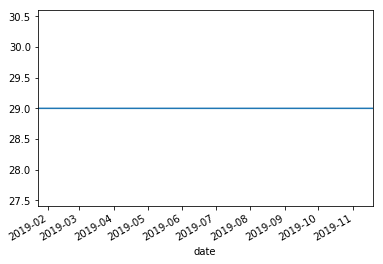

In [18]:
df [df.num1 == 344 ].num2.plot()
plt.show()

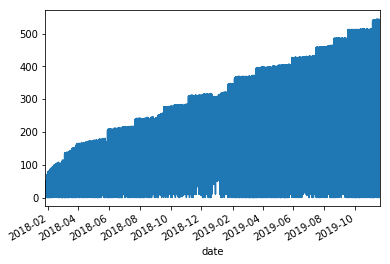

In [19]:
df.num1.plot()
plt.show()

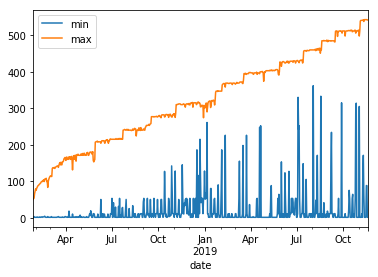

In [20]:
df.num1.resample("D").min().plot(label="min")
df.num1.resample("D").max().plot(label="max")
plt.legend()
plt.show()

> I still don't know what these values are

### Dive into num2

In [21]:
df.num2.describe()

count    372441.000000
mean         26.912649
std           7.846146
min           1.000000
25%          23.000000
50%          27.000000
75%          31.000000
max          52.000000
Name: num2, dtype: float64

In [22]:
df.num2.value_counts()

29.0    35969
24.0    35039
33.0    34433
22.0    28875
23.0    28056
32.0    26801
26.0    26760
25.0    25233
31.0    22665
28.0    20677
27.0    20198
34.0    15519
51.0    10835
14.0     9069
1.0      8877
21.0     7181
17.0     3792
52.0     2896
13.0     2610
8.0      1671
18.0     1603
19.0     1142
16.0      740
15.0      691
7.0       461
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
Name: num2, dtype: int64

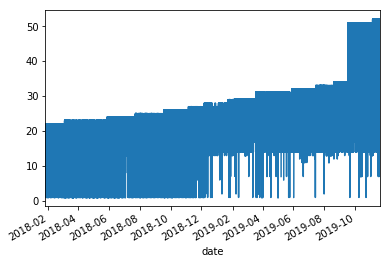

In [23]:
df.num2.plot()
plt.show()

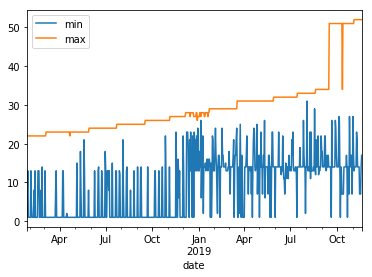

In [24]:
df.num2.resample("D").min().plot(label="min")
df.num2.resample("D").max().plot(label="max")
plt.legend()
plt.show()

In [25]:
df[["num1","num2"]].groupby("num2").agg(["min","max"])

num1     
      min  max
num2          
1.0    11  402
2.0   144  396
4.0    85   85
6.0   283  405
7.0    77  513
8.0     1  174
9.0   152  152
11.0   88  463
12.0   88  214
13.0   50  318
14.0   53  246
15.0   72  427
16.0   21  322
17.0  102  465
18.0   26  217
19.0   37  486
21.0   10  346
22.0    2  459
23.0   25  319
24.0  182  278
25.0  218  282
26.0  259  315
27.0  287  401
28.0    1  539
29.0  323  347
31.0  373  464
32.0  407  426
33.0  433  543
34.0  358  487
51.0  488  512
52.0  516  542

> what are y'all

In [26]:
df [df.num2 == 34 ]

,page,num1,num2,ip
date,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58
2019-08-20 09:39:59,/,467,34.0,97.105.19.58
2019-08-20 09:39:59,/,468,34.0,97.105.19.58
2019-08-20 09:40:02,/,469,34.0,97.105.19.58
2019-08-20 09:40:08,/,470,34.0,97.105.19.58
...,...,...,...,...
2019-11-19 10:02:38,9-timeseries/3-prep,467,34.0,97.105.19.58
2019-11-19 10:03:01,9-timeseries/2-acquire,475,34.0,97.105.19.58
2019-11-19 10:05:00,9-timeseries/project,472,34.0,97.105.19.58


In [27]:
len(df [df.num2 == 34 ].num1.value_counts())

22

In [28]:
df [df.num1 == 479 ].head(35)

,page,num1,num2,ip
date,,,,
2019-08-20 09:40:40,/,479,34.0,97.105.19.58
2019-08-20 09:40:50,appendix/cli-git-overview,479,34.0,97.105.19.58
2019-08-20 09:42:44,/,479,34.0,97.105.19.58
2019-08-20 10:46:56,1-fundamentals/1.1-intro-to-data-science,479,34.0,97.105.19.58
2019-08-20 10:46:56,1-fundamentals/modern-data-scientist.jpg,479,34.0,97.105.19.58
2019-08-20 10:46:56,1-fundamentals/AI-ML-DL-timeline.jpg,479,34.0,97.105.19.58
2019-08-20 15:03:35,1-fundamentals/1.2-data-science-pipeline,479,34.0,97.105.19.58
2019-08-20 15:03:35,1-fundamentals/DataToAction_v2.jpg,479,34.0,97.105.19.58
2019-08-20 15:04:17,1-fundamentals/1.3-pipeline-demo,479,34.0,97.105.19.58


I believe that num1 is each person's individial id number (associated with with github account) and num2 is the related to the cohort. 
- num2 = 34 is the bayes cohort
- There are 22 id's in the bayes cohort
- We only started with 21 students in the class
- But one person only viewed the curriculum 17 times, so DO THEY EVEN GO HERE? 

In [29]:
for id in df [ df.num2 == 34 ].num1.unique():
    print(id)
    print(df [df.num1 == id].ip.unique())
    print()

466
['97.105.19.58' '70.226.110.58' '71.78.109.210']

467
['97.105.19.58' '173.173.105.24' '192.171.117.210']

468
['97.105.19.58' '173.175.104.33' '136.50.54.2' '70.121.200.203'
 '67.11.124.64' '67.79.62.147']

469
['97.105.19.58' '67.11.115.125']

470
['97.105.19.58' '66.69.81.250' '12.247.3.50' '192.171.117.210']

471
['97.105.19.58' '216.110.79.11' '99.158.246.101' '99.158.247.1'
 '75.4.99.66' '192.171.117.210']

472
['97.105.19.58' '173.149.142.35' '67.11.82.11' '173.127.7.219'
 '173.127.93.78' '184.226.46.205' '67.48.59.123' '166.251.106.216'
 '67.11.120.157' '12.97.187.16' '166.251.101.230' '12.97.187.13'
 '12.97.187.15' '184.203.5.0' '184.203.21.120' '184.226.92.76']

473
['97.105.19.58' '67.10.174.4' '208.54.86.133' '172.56.7.16' '172.56.7.112'
 '208.54.86.240' '172.58.110.227' '172.58.110.148' '172.58.107.104'
 '172.58.70.158' '172.58.107.139' '71.42.230.162']

474
['97.105.19.58' '108.174.80.231' '192.171.117.210']

475
['97.105.19.58' '70.226.109.182']

476
['97.105.19.58' 

Dat's us! Which one is me?! The professors obviously aren't included in this list. And they will mostly span past the regular cohort time. I should be able to easily identify DS instructor ids as folks who were accessing the cirrculum between Ada and Bayes cohorts (between June and August). Perhaps all instructors and staff don't have a cohort_id and that's why there are nulls in that column.

In [30]:
# rename columns to be reflective of newfound data
df.rename(columns={"num1":"person_id", "num2":"cohort_id"}, inplace=True)

#### Dive into my own id

In [31]:
# look at my activity
df [df.person_id == 481]

,page,person_id,cohort_id,ip
date,,,,
2019-08-20 09:40:52,/,481,34.0,97.105.19.58
2019-08-20 10:08:39,/,481,34.0,97.105.19.58
2019-08-20 10:46:28,1-fundamentals/1.1-intro-to-data-science,481,34.0,97.105.19.58
2019-08-20 10:46:28,1-fundamentals/modern-data-scientist.jpg,481,34.0,97.105.19.58
2019-08-20 10:46:28,1-fundamentals/AI-ML-DL-timeline.jpg,481,34.0,97.105.19.58
...,...,...,...,...
2019-11-17 16:35:43,9-timeseries/3-prep,481,34.0,107.132.82.186
2019-11-18 09:04:05,9-timeseries/4-explore,481,34.0,97.105.19.58
2019-11-18 13:37:08,9-timeseries/5.1-modeling-lesson1,481,34.0,97.105.19.58


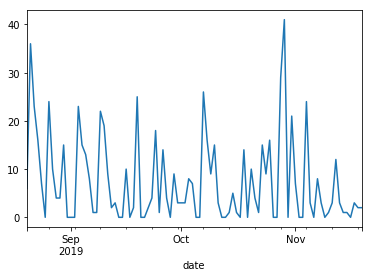

In [32]:
df [df.person_id == 481].page.resample("D").count().plot()
plt.show()

> me accessing the curriculum

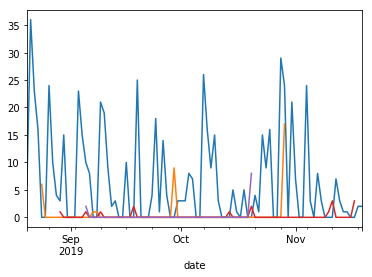

In [33]:
# plot me accessing the cirruculum at different ips
for x in df [df.person_id == 481].ip.unique():
    df [(df.person_id == 481) & (df.ip == x)].resample("D").count().ip.plot()
plt.show()

In [34]:
df [df.ip == "66.25.146.95"]

,page,person_id,cohort_id,ip
date,,,,
2019-10-18 20:21:55,6-regression/2.0-acquire-and-prep,481,34.0,66.25.146.95
2019-10-18 20:22:00,6-regression/4.0-explore,481,34.0,66.25.146.95
2019-10-18 20:22:05,6-regression/1-overview,481,34.0,66.25.146.95
2019-10-18 20:22:06,appendix/cli-git-overview,481,34.0,66.25.146.95
2019-10-18 20:22:10,5-stats/1-overview,481,34.0,66.25.146.95
2019-10-18 20:22:12,5-stats/2-simulation,481,34.0,66.25.146.95
2019-10-18 20:22:14,5-stats/3-probability-distributions,481,34.0,66.25.146.95
2019-10-18 20:22:17,5-stats/5-power-analysis,481,34.0,66.25.146.95
2019-10-18 20:22:20,5-stats/4.2-compare-means,481,34.0,66.25.146.95


#### Dive into folks without cohort_ids

In [35]:
# non student ids and the number of times they have accessed the cirruculum 
df [df.cohort_id.isnull()].person_id.value_counts()

354    2821
363    2237
368    2063
349    1593
48     1470
355    1436
353    1370
362    1150
366    1051
367    1042
372     867
61      816
351     789
352     767
111     753
361     727
364     637
357     605
359     519
58      462
369     442
403     418
365     331
429     304
360     251
88      223
79      191
86      177
54      146
358     138
375     132
350      87
406      87
73       84
74       80
166      77
317      73
247      66
100      59
78       53
59       42
103      42
63       22
356      21
213      13
137      10
62        4
89        3
176       3
Name: person_id, dtype: int64

### Dive into page

In [36]:
df.page.value_counts()

/                             20564
javascript-i                   8140
search/search_index.json       7005
toc                            6679
html-css                       6143
                              ...  
extra-features/file-upload        1
133                               1
effects                           1
student-page                      1
cohorts/27/quizzes                1
Name: page, Length: 1641, dtype: int64

> Do they need cleanup? Inital glance implies not. I'm sure that is a lie. 

### Dive into ip

In [37]:
df.ip.value_counts()

97.105.19.58       227220
97.105.19.61        61662
192.171.117.210      8127
70.122.40.62         1338
66.69.108.117        1199
                    ...  
201.163.149.250         1
103.208.220.137         1
173.239.232.122         1
104.237.80.34           1
99.203.27.110           1
Name: ip, Length: 2585, dtype: int64

### Hi entropy 

In [38]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [39]:
for col in df.columns:
    print(col)
    print(compute_entropy(df[col]))
    print()

page
5.421441033159647

person_id
5.766669123461863

cohort_id
3.571745194506109

ip
2.681171415737275



As expected. High entropy for all columns.

## Investigate 

In [40]:
df.head()

,page,person_id,cohort_id,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


I know cohorts are about 18 weeks long. For each cohort, I will probably want to look at a cohorts logs by time, and attempt to see if there are folks spikes in people who are anomolies in viewing the curriculum.

How do I do that? I dunno

Why would I split into train and test? I want to look at all the data. Do a split into test at the end of the cohort? For each cohort? Is that what I'm supposed to be doing? That seems tedious.

The lack of spell check on here annoys me. 

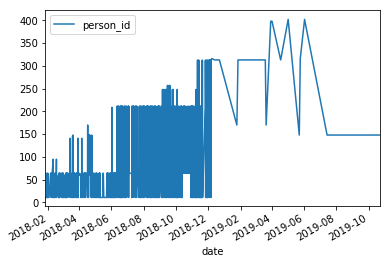

In [41]:
# plot a single cohort vs time
df [df.cohort_id == 1].reset_index().drop("cohort_id",axis=1).plot(x="date")
plt.show()

In [42]:
# reveal the person ids in cohort 1
df [df.cohort_id == 1].person_id.unique()

array([ 11,  60,  64,  95, 141, 146, 148, 170, 209, 211, 212, 248, 257,
       312, 313, 316, 398, 402])

### Find the cohort ids that seem to be associated with a full class

In [43]:
cohort_w_students = []
cohort_maybe = []
for cohort in sorted(df.cohort_id.dropna().unique()):
    x = len(df [df.cohort_id == cohort].person_id.unique())
    print("cohort {} number has {} ids".format(int(cohort), x))
    if x > 15:
        cohort_w_students.append(int(cohort))
    else:
        cohort_maybe.append(int(cohort))

cohort 1 number has 18 ids
cohort 2 number has 3 ids
cohort 4 number has 1 ids
cohort 6 number has 2 ids
cohort 7 number has 6 ids
cohort 8 number has 4 ids
cohort 9 number has 1 ids
cohort 11 number has 5 ids
cohort 12 number has 4 ids
cohort 13 number has 10 ids
cohort 14 number has 10 ids
cohort 15 number has 5 ids
cohort 16 number has 8 ids
cohort 17 number has 12 ids
cohort 18 number has 13 ids
cohort 19 number has 16 ids
cohort 21 number has 28 ids
cohort 22 number has 35 ids
cohort 23 number has 33 ids
cohort 24 number has 33 ids
cohort 25 number has 26 ids
cohort 26 number has 20 ids
cohort 27 number has 28 ids
cohort 28 number has 19 ids
cohort 29 number has 25 ids
cohort 31 number has 28 ids
cohort 32 number has 20 ids
cohort 33 number has 29 ids
cohort 34 number has 22 ids
cohort 51 number has 25 ids
cohort 52 number has 27 ids


In [44]:
cohort_w_students

[1, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 51, 52]

In [45]:
cohort_maybe

[2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]

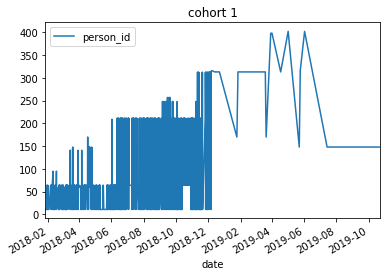

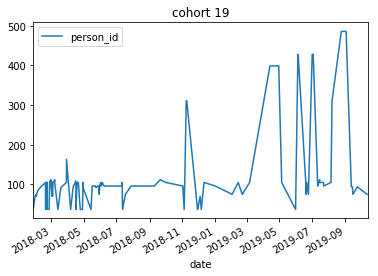

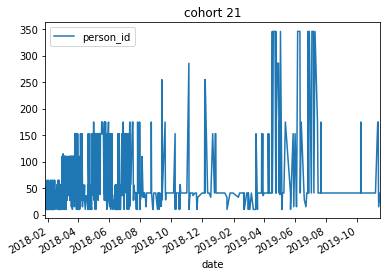

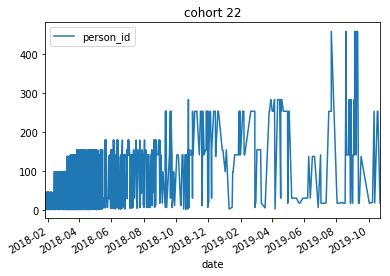

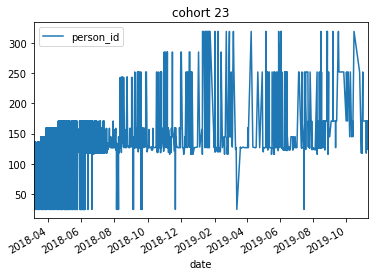

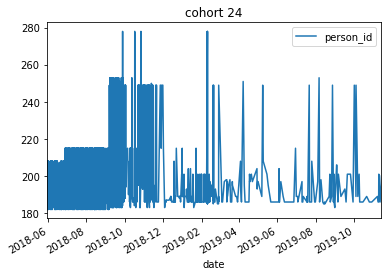

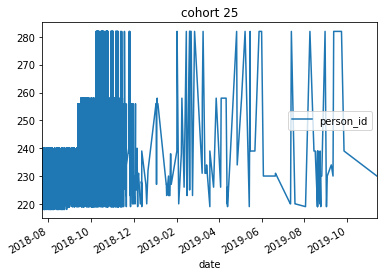

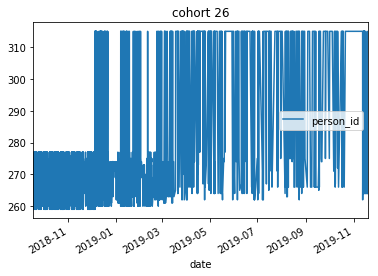

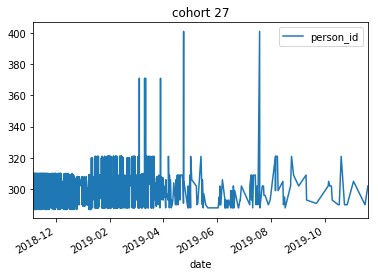

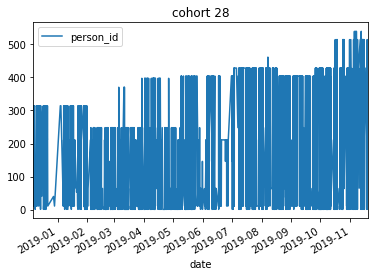

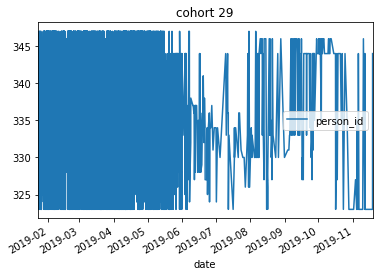

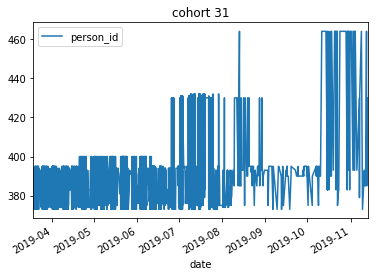

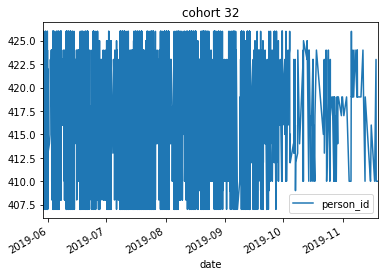

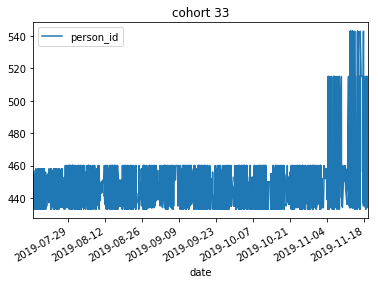

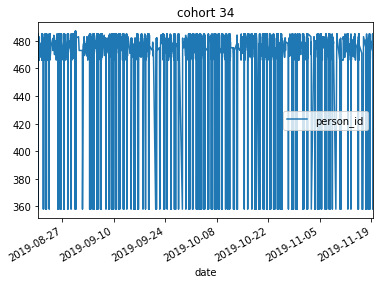

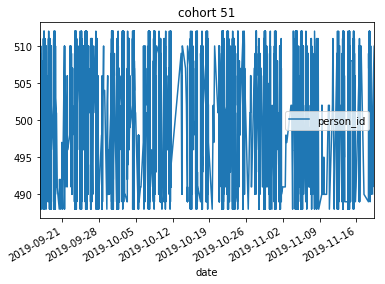

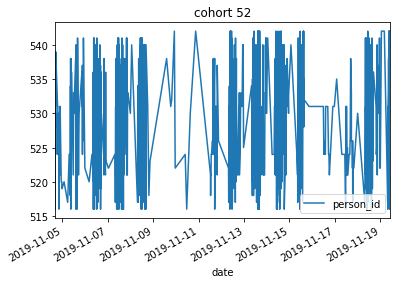

In [46]:
for x in cohort_w_students: 
    df [df.cohort_id == x].drop("cohort_id",axis=1).reset_index().plot(x="date")
    plt.title("cohort {}".format(x))
    plt.show()

### Cluster

What variables would I like to observe? 

In [47]:
df

,page,person_id,cohort_id,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...
2019-11-19 10:06:28,spring/fundamentals/controllers,445,33.0,97.105.19.58
2019-11-19 10:06:50,spring/fundamentals/views,445,33.0,97.105.19.58
2019-11-19 10:07:03,8-clustering/3-wrangle,475,34.0,97.105.19.58


For now, I'll cluster on person_id and cohort_id

In [80]:
df1 = df[["person_id","cohort_id"]].dropna()
df1

,person_id,cohort_id
date,,
2018-01-26 09:55:03,1,8.0
2018-01-26 09:56:02,1,8.0
2018-01-26 09:56:05,1,8.0
2018-01-26 09:56:06,1,8.0
2018-01-26 09:56:24,2,22.0
...,...,...
2019-11-19 10:06:28,445,33.0
2019-11-19 10:06:50,445,33.0
2019-11-19 10:07:03,475,34.0


In [82]:
df.resample("D").count()

,page,person_id,cohort_id,ip
date,,,,
2018-01-26,572,572,533,572
2018-01-27,230,230,230,230
2018-01-28,170,170,168,170
2018-01-29,830,830,783,830
2018-01-30,652,652,614,652
...,...,...,...,...
2019-11-15,759,759,742,759
2019-11-16,129,129,128,129
2019-11-17,185,185,185,185


In [52]:
df1 = df1.head(1000)

In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2018-01-26 09:55:03 to 2018-01-29 09:25:42
Data columns (total 2 columns):
person_id    1000 non-null int64
cohort_id    1000 non-null float64
dtypes: float64(1), int64(1)
memory usage: 23.4 KB


In [54]:
np_array = np.array(df1)
np_array

array([[ 1.,  8.],
       [ 1.,  8.],
       [ 1.,  8.],
       ...,
       [55., 21.],
       [55., 21.],
       [55., 21.]])

In [55]:
stscale = StandardScaler().fit(np_array)
stscale

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
np_array = stscale.transform(np_array)
np_array

array([[-1.33898574, -3.39285083],
       [-1.33898574, -3.39285083],
       [-1.33898574, -3.39285083],
       ...,
       [ 2.12357676,  0.13825643],
       [ 2.12357676,  0.13825643],
       [ 2.12357676,  0.13825643]])

In [61]:
dbsc = DBSCAN(eps=.5, min_samples=5).fit(np_array)

In [63]:
labels = dbsc.labels_

In [64]:
df1["labels"] = labels

In [66]:
df1.labels.value_counts(dropna=False)

 1    895
 3     68
 2     19
-1     10
 0      8
Name: labels, dtype: int64

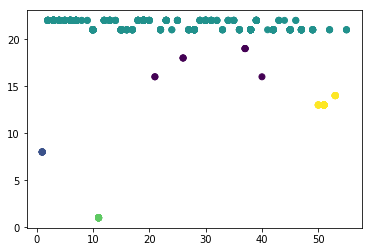

In [79]:
plt.scatter(x=df1.person_id, y=df1.cohort_id, c=df1.labels)
plt.show()